moon surface brightness is currently calculated by renormalizing the moon spectrum by the KS model V-band magnitude
```python
scattered_V = krisciunas_schaefer(obs_zenith, moon_zenith, separation_angle, moon_phase, vband_extinction)

# Calculate the wavelength-dependent extinction of moonlight
# scattered once into the observed field of view.
scattering_airmass = (1 - 0.96 * np.sin(moon_zenith) ** 2) ** (-0.5)
extinction = (10**(-extinction_coefficient * scattering_airmass / 2.5) * (1 - 10**(-extinction_coefficient * airmass / 2.5)))

surface_brightness = moon_spectrum * extinction

# Renormalized the extincted spectrum to the correct V-band magnitude.
raw_V = _vband.get_ab_magnitude(surface_brightness, wavelength) * u.mag

area = 1 * u.arcsec ** 2
surface_brightness *= 10 ** (-(scattered_V * area - raw_V) / (2.5 * u.mag)) / area
```

Instead of the KS model V-band magnitude, lets see if we can improve the sky model by implementing a direct prediction for V-band magnitude. 

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import h5py
import fitsio
import numpy as np 
from astropy import units as u
from scipy.signal import medfilt, medfilt2d
from scipy.interpolate import interp1d
from feasibgs import skymodel as Sky

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
dir_cmx = '/Users/ChangHoon/data/feasiBGS/cmx/'
dir_sky = '/Users/ChangHoon/data/feasiBGS/sky/'

In [4]:
desi_fiber_area = (1.46/2.)**2 * np.pi
boss_fiber_area = np.pi

In [5]:
def read_cmx_skies(): 
    ''' read CMX sky fibers and return median sky surface brightness measurements for each exposure
    '''
    fsky = h5py.File(os.path.join(dir_cmx, 'sky_fibers.coadd_gfa.minisv2_sv0.hdf5'), 'r')

    sky_data = {}
    for k in fsky.keys():
        sky_data[k] = fsky[k][...]
        
    bad_seeing = (sky_data['tileid'] == 70502) | (sky_data['date'] == 20200314) #bad seeing on Feb 25 and 27

    exp_cuts = ~bad_seeing

    for k in sky_data.keys(): 
        if 'wave' not in k: 
            sky_data[k] = sky_data[k][exp_cuts]
        else:
            sky_data[k] = sky_data[k]
            
    uniq_exps, i_uniq = np.unique(sky_data['expid'], return_index=True)

    # compile median observing conditions for each unique exposure and
    # get the median sky fluxes of all sky fibers
    sky_uniq_exps = {} 
    for k in ['airmass', 'moon_ill', 'moon_alt', 'moon_sep', 'exptime']: 
        sky_uniq_exps[k] = np.zeros(len(uniq_exps))

    sky_uniq_exps['wave_b'] = sky_data['wave_b']
    sky_uniq_exps['wave_r'] = sky_data['wave_r']
    sky_uniq_exps['wave_z'] = sky_data['wave_z']
    wave_concat = np.concatenate([sky_data['wave_b'], sky_data['wave_r'], sky_data['wave_z']])
    wave_sort = np.argsort(wave_concat)
    sky_uniq_exps['wave'] = wave_concat[wave_sort]
    
    sky_uniq_exps['sky_b'] = np.zeros((len(uniq_exps), len(sky_data['wave_b'])))
    sky_uniq_exps['sky_r'] = np.zeros((len(uniq_exps), len(sky_data['wave_r'])))
    sky_uniq_exps['sky_z'] = np.zeros((len(uniq_exps), len(sky_data['wave_z'])))
    sky_uniq_exps['sky'] = np.zeros((len(uniq_exps), len(sky_uniq_exps['wave'])))

    print('date \t\t tile \t exp \t texp \t airmass \t moon_ill \t moon_alt \t moon_sep')
    for _i, _i_uniq, _exp in zip(range(len(i_uniq)), i_uniq, uniq_exps): 
        _is_exp = (sky_data['expid'] == _exp)

        sky_uniq_exps['airmass'][_i] = np.median(sky_data['airmass'][_is_exp])
        sky_uniq_exps['moon_ill'][_i] = np.median(sky_data['moon_ill'][_is_exp])
        sky_uniq_exps['moon_alt'][_i] = np.median(sky_data['moon_alt'][_is_exp])
        sky_uniq_exps['moon_sep'][_i] = np.median(sky_data['moon_sep'][_is_exp])
        sky_uniq_exps['exptime'][_i] = sky_data['exptime'][_is_exp][0]
        
        sky_uniq_exps['sky_b'][_i] = np.median(sky_data['sky_b'][_is_exp], axis=0) / desi_fiber_area
        sky_uniq_exps['sky_r'][_i] = np.median(sky_data['sky_r'][_is_exp], axis=0) / desi_fiber_area
        sky_uniq_exps['sky_z'][_i] = np.median(sky_data['sky_z'][_is_exp], axis=0) / desi_fiber_area
        sky_uniq_exps['sky'][_i] = np.concatenate([sky_uniq_exps['sky_b'][_i], sky_uniq_exps['sky_r'][_i], sky_uniq_exps['sky_z'][_i]])[wave_sort]

        print('%i \t %i \t %i \t %.f \t %.2f \t\t %.2f \t\t %.1f \t\t %f' % 
              (sky_data['date'][_i_uniq], sky_data['tileid'][_i_uniq], sky_data['expid'][_i_uniq], 
               sky_uniq_exps['exptime'][_i], 
               sky_uniq_exps['airmass'][_i], sky_uniq_exps['moon_ill'][_i], 
               sky_uniq_exps['moon_alt'][_i], sky_uniq_exps['moon_sep'][_i]))

    return sky_uniq_exps

In [6]:
def read_BOSS_skies(): 
    ''' read sky fibers from BOSS
    '''
    f_boss = os.path.join(dir_sky, 'Bright_BOSS_Sky_blue.fits')
    boss = fitsio.read(f_boss)    
    f_red = os.path.join(dir_sky, 'Bright_BOSS_Sky_red.fits')
    red = fitsio.read(f_red)
    
    sky_boss = {} 
    sky_boss['airmass'] = boss['AIRMASS']
    sky_boss['moon_ill'] = boss['MOON_ILL']
    sky_boss['moon_alt'] = boss['MOON_ALT']
    sky_boss['moon_sep'] = boss['MOON_SEP']
    
    sky_boss['wave_b'] = boss['WAVE'][0] * 10. # convert to Angstroms
    sky_boss['sky_b'] = boss['SKY'] / boss_fiber_area
    sky_boss['wave_r'] = red['WAVE'][0] * 10.
    sky_boss['sky_r'] = red['SKY'] / boss_fiber_area
    
    wave_concat = np.concatenate([sky_boss['wave_b'], sky_boss['wave_r']])
    wave_sort = np.argsort(wave_concat)
    sky_boss['wave'] = wave_concat[wave_sort]
    sky_boss['sky'] = np.zeros((len(sky_boss['airmass']), len(wave_concat)))
    for i in range(len(sky_boss['airmass'])): 
        sky_boss['sky'][i] = np.concatenate([sky_boss['sky_b'][i], sky_boss['sky_r'][i]])[wave_sort]
    return sky_boss

In [7]:
desi_skies = read_cmx_skies()

date 		 tile 	 exp 	 texp 	 airmass 	 moon_ill 	 moon_alt 	 moon_sep
20200303 	 70500 	 52932 	 500 	 1.15 		 0.65 		 35.8 		 34.694952
20200303 	 70500 	 52934 	 500 	 1.19 		 0.65 		 31.0 		 34.560475
20200303 	 70500 	 52936 	 500 	 1.25 		 0.65 		 26.2 		 34.426285
20200303 	 70500 	 52938 	 500 	 1.31 		 0.65 		 21.6 		 34.295422
20200303 	 70500 	 52940 	 500 	 1.39 		 0.65 		 17.0 		 34.164750
20200303 	 70500 	 52942 	 500 	 1.49 		 0.66 		 12.2 		 34.028773
20200304 	 70510 	 53078 	 500 	 1.43 		 0.74 		 55.8 		 79.213270
20200304 	 70510 	 53080 	 500 	 1.34 		 0.75 		 52.1 		 79.065745
20200304 	 70510 	 53081 	 500 	 1.29 		 0.75 		 49.2 		 78.948088
20200304 	 70510 	 53082 	 500 	 1.24 		 0.75 		 46.4 		 78.831239
20200304 	 70510 	 53083 	 500 	 1.19 		 0.75 		 43.5 		 78.713989
20200304 	 70510 	 53084 	 500 	 1.16 		 0.75 		 40.7 		 78.597620
20200304 	 70510 	 53085 	 500 	 1.13 		 0.75 		 37.8 		 78.480931
20200304 	 70510 	 53086 	 500 	 1.10 		 0.75 		 34.9 		 78.

In [8]:
boss_skies = read_BOSS_skies()

[]

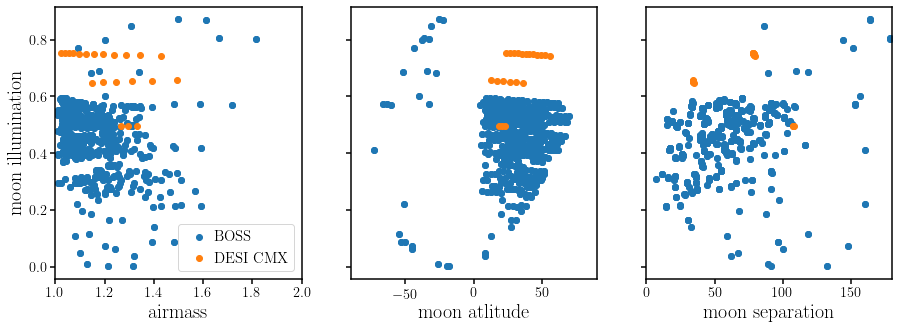

In [9]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c='C0', label='BOSS')
sub.scatter(desi_skies['airmass'], desi_skies['moon_ill'], c='C1', label='DESI CMX')
sub.legend(loc='lower right', frameon=True, handletextpad=0, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c='C0')
sub.scatter(desi_skies['moon_alt'], desi_skies['moon_ill'], c='C1')
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c='C0', label='BOSS')
sub.scatter(desi_skies['moon_sep'], desi_skies['moon_ill'], c='C1', label='DESI CMX')
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

Lets calculate the scattered V-band magnitude for all BOSS and DESI exposures

In [10]:
specsim_sky = Sky._specsim_initialize('desi')
specsim_wave = specsim_sky._wavelength # Ang

dark_spectrum = specsim_sky._surface_brightness_dict['dark']

In [11]:
def get_scattered_V(wave, _Isky, airmass, moon_alt): 
    ''' given sky surface brightness and observing conditions approximate the scattered V value
    '''
    # interpolation to specsim wavelenght
    Isky = interp1d(wave, _Isky, bounds_error=False, fill_value=0.)(specsim_wave) * 1e-17 * u.erg/u.Angstrom/u.s/u.arcsec**2/u.cm**2
    
    # subtract dark sky surface brightness to get moon contribution
    extinction = 10 ** (-specsim_sky.moon._extinction_coefficient * airmass / 2.5)
    Idark = dark_spectrum * extinction
    Imoon = np.clip(Isky - Idark, 0., None)

    area = 1 * u.arcsec ** 2 
    scattered_V = specsim_sky.moon._vband.get_ab_magnitude(Imoon[np.isfinite(Imoon)] * area, specsim_wave[np.isfinite(Imoon)])
    return scattered_V# * u.mag / u.arcsec**2

In [12]:
def KS_Vband(airmass, moonill, moonalt, moonsep):
    ''' scattered V-band moon magnitude from re-fit KS model
    '''
    specsim_sky.airmass = airmass
    specsim_sky.moon.moon_phase = np.arccos(2.*moonill - 1)/np.pi
    specsim_sky.moon.moon_zenith = (90. - moonalt) * u.deg
    specsim_sky.moon.separation_angle = moonsep * u.deg

    scattered_V = Sky.krisciunas_schaefer_free(
        specsim_sky.moon.obs_zenith, 
        specsim_sky.moon.moon_zenith, 
        specsim_sky.moon.separation_angle, 
        specsim_sky.moon.moon_phase, 
        specsim_sky.moon.vband_extinction,
        specsim_sky.moon.KS_CR, 
        specsim_sky.moon.KS_CM0,
        specsim_sky.moon.KS_CM1,        
        specsim_sky.moon.KS_M0, 
        specsim_sky.moon.KS_M1,
        specsim_sky.moon.KS_M2)
    return scattered_V.value

In [13]:
boss_scattered_V = [get_scattered_V(boss_skies['wave'], boss_skies['sky'][i], boss_skies['airmass'][i], boss_skies['moon_alt'][i]) for i in range(len(boss_skies['airmass']))]
desi_scattered_V = [get_scattered_V(desi_skies['wave'], desi_skies['sky'][i], desi_skies['airmass'][i], desi_skies['moon_alt'][i]) for i in range(len(desi_skies['airmass']))]

In [14]:
boss_scattered_V_KS = [KS_Vband(boss_skies['airmass'][i], boss_skies['moon_ill'][i], boss_skies['moon_alt'][i], boss_skies['moon_sep'][i]) for i in range(len(boss_skies['airmass']))]
desi_scattered_V_KS = [KS_Vband(desi_skies['airmass'][i], desi_skies['moon_ill'][i], desi_skies['moon_alt'][i], desi_skies['moon_sep'][i]) for i in range(len(desi_skies['airmass']))]

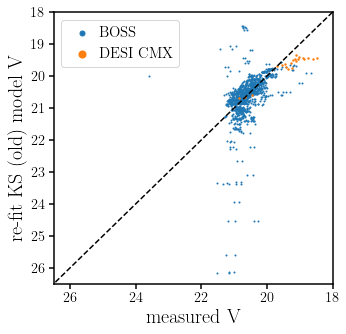

In [15]:
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.scatter(boss_scattered_V, boss_scattered_V_KS, c='C0', s=1, label='BOSS')
sub.scatter(desi_scattered_V, desi_scattered_V_KS, c='C1', s=2, label='DESI CMX')
sub.plot([18., 26.5], [18., 26.5], c='k', ls='--')
sub.set_xlabel('measured V', fontsize=20)
sub.set_xlim(26.5, 18)
sub.set_ylabel('re-fit KS (old) model V', fontsize=20)
sub.set_ylim(26.5, 18.)
sub.legend(loc='upper left', markerscale=5, handletextpad=0.1, fontsize=15, frameon=True)

Text(0, 0.5, 'scattered moonlight surface brightness in V band')

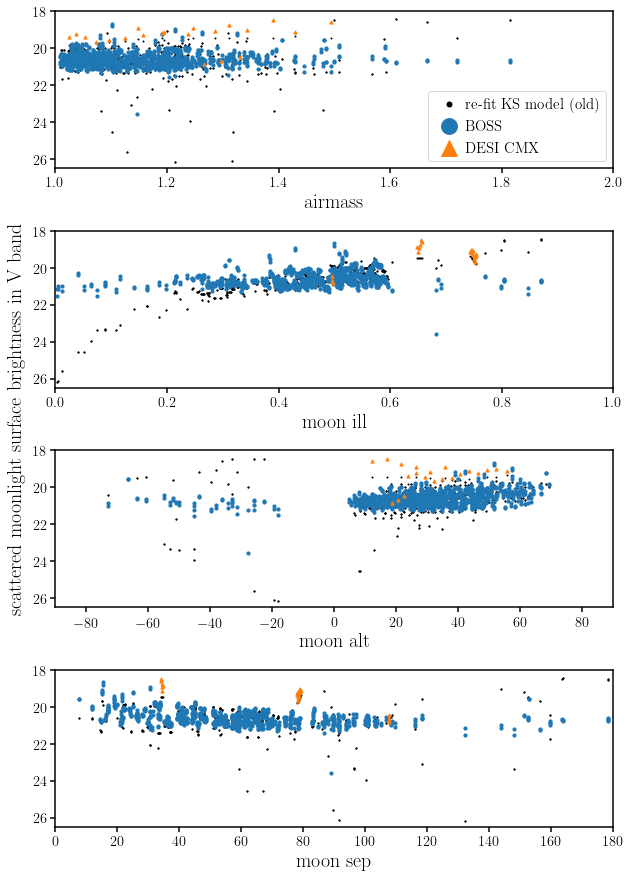

In [16]:
cols = ['airmass', 'moon_ill', 'moon_alt', 'moon_sep']
lbls = ['airmass', 'moon ill', 'moon alt', 'moon sep']
lims = [(1., 2.), (0., 1.), (-90., 90.), (0., 180.)]

fig = plt.figure(figsize=(10,15))
for i, k in enumerate(cols): 
    sub = fig.add_subplot(len(cols),1,i+1)
    sub.scatter(boss_skies[k], boss_scattered_V_KS, c='k', s=1)
    sub.scatter(desi_skies[k], desi_scattered_V_KS, c='k', s=1, label='re-fit KS model (old)')
    
    sub.scatter(boss_skies[k], boss_scattered_V, c='C0', s=10, label='BOSS')
    sub.scatter(desi_skies[k], desi_scattered_V, c='C1', s=10, marker='^', label='DESI CMX')
    sub.set_xlabel(lbls[i], fontsize=20)
    sub.set_xlim(lims[i])
    sub.set_ylim(26.5, 18.)
    if i == 0: sub.legend(loc='lower right', markerscale=5, handletextpad=0.1, fontsize=15, frameon=True)
fig.subplots_adjust(hspace=0.4)

bkgd = fig.add_subplot(111, frameon=False)
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
bkgd.set_ylabel('scattered moonlight surface brightness in V band', fontsize=20)

In [17]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from itertools import chain, combinations_with_replacement

In [18]:
theta_train, theta_test, v_train, v_test = train_test_split(
    np.vstack([
        np.concatenate([desi_skies['airmass'], boss_skies['airmass']]),
        np.concatenate([desi_skies['moon_ill'], boss_skies['moon_ill']]),
        np.concatenate([desi_skies['moon_alt'], boss_skies['moon_alt']]),
        np.concatenate([desi_skies['moon_sep'], boss_skies['moon_sep']])]).T, 
    np.concatenate([desi_scattered_V, boss_scattered_V]), 
    test_size=0.1, 
    random_state=0)

In [19]:
n_order = 4
regress_v = make_pipeline(PolynomialFeatures(n_order), LinearRegression())
regress_v.fit(theta_train, v_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=4, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [20]:
steps = regress_v.get_params()
coeffs = steps['linearregression'].coef_
intercept = steps['linearregression'].intercept_
print(coeffs)
print(intercept)

[-1.72523347e-02 -1.31361477e+02  6.63730935e+01 -9.41030359e-02
  8.48961915e-01  2.17497311e+02 -3.72597558e+02  1.00758992e+00
  3.08696159e-01  2.67636483e+02  8.35770985e-03  2.23588689e-01
  2.50034199e-03 -1.31082188e-02 -1.78405038e-02 -1.33394254e+02
  3.59991736e+02 -1.20301999e+00 -1.15591783e+00 -2.08943993e+02
  3.16669904e-01  4.73848984e-01  2.19641193e-03  1.03678764e-02
  1.05647754e-02  5.97639216e+01 -3.29778699e+00 -3.53949915e+00
  1.15924972e-02  2.26256920e-02  1.10537908e-02 -9.30849402e-05
 -9.24348638e-05  6.08290452e-05  7.47429090e-05  2.87743547e+01
 -1.06004742e+02  3.49781288e-01  4.15966437e-01  5.02510051e+01
  2.33158177e-01 -8.99504191e-02 -1.55945957e-03 -1.67962218e-03
 -1.48167087e-03 -6.79449418e+01  9.24990594e-01  1.74126599e+00
 -6.98329328e-03 -1.67072349e-02 -9.48908504e-03  1.71830097e-05
  1.53753423e-05 -1.20825222e-05 -1.10402948e-05 -6.82883124e+00
  3.42104080e-01  1.15313005e-01  1.08055005e-02  1.62673968e-02
  6.95873457e-03 -3.37508

In [21]:
def scattered_V_model(airmass, moon_frac, moon_alt, moon_sep):
    ''' third degree polynomial regression fit to exposure factor
    '''
    theta = np.atleast_2d(np.array([airmass, moon_frac, moon_alt, moon_sep]).T)

    combs = chain.from_iterable(combinations_with_replacement(range(4), i) for i in range(0, n_order+1))
    theta_transform = np.empty((theta.shape[0], len(coeffs)))
    for i, comb in enumerate(combs):
        theta_transform[:, i] = theta[:, comb].prod(1)

    return np.dot(theta_transform, coeffs.T) + intercept

(26.5, 18.0)

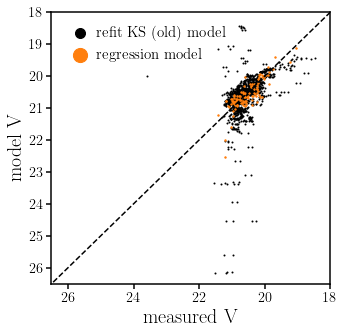

In [22]:
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.scatter(np.concatenate([desi_scattered_V, boss_scattered_V]), 
            np.concatenate([desi_scattered_V_KS, boss_scattered_V_KS]), c='k', s=1, label='refit KS (old) model')
sub.scatter(v_test, regress_v.predict(theta_test), c='C1', s=2, label='regression model')
sub.plot([18., 26.5], [18., 26.5], c='k', ls='--')
sub.legend(loc='upper left', markerscale=10, handletextpad=0.1, fontsize=15)
sub.set_xlabel('measured V', fontsize=20)
sub.set_xlim(26.5, 18)
sub.set_ylabel('model V', fontsize=20)
sub.set_ylim(26.5, 18.)

(22.0, 18.0)

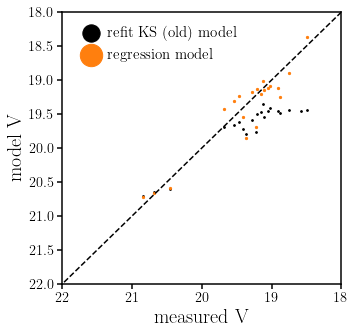

In [35]:
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.scatter(desi_scattered_V, desi_scattered_V_KS, c='k', s=3, label='refit KS (old) model')
sub.scatter(desi_scattered_V, 
            regress_v.predict(np.vstack([desi_skies['airmass'], desi_skies['moon_ill'], desi_skies['moon_alt'], desi_skies['moon_sep']]).T), 
            c='C1', s=5, label='regression model')
sub.plot([18., 22], [18., 22], c='k', ls='--')
sub.legend(loc='upper left', markerscale=10, handletextpad=0.1, fontsize=15)
sub.set_xlabel('measured V', fontsize=20)
sub.set_xlim(22, 18)
sub.set_ylabel('model V', fontsize=20)
sub.set_ylim(22, 18.)

Now lets see how much better a sky model based on the regression scattered V band moon light reproduces sky brightness compared to the old KS model. Lets compare the sky brightness at 4500 and 5500 Angstroms

In [24]:
def get_continuum(flux, data_set='desi'):
    if data_set == 'desi': 
        cont = medfilt(flux, 151) 
    elif data_set == 'boss': 
        cont = medfilt(flux[::10], 121)
    return cont

def get_sky_at_wavelength(wave, sky, wavelength=4500, data_set='desi'): 
    ''' given wavelength and surface brightness, return the value of the 
    continuum at ~4500A
    '''
    if data_set == 'boss': wave = wave[::10]
    near_wave = (wave > wavelength-5.) & (wave < wavelength+5.)
    assert np.sum(near_wave) > 0
    
    sky_cont = get_continuum(sky, data_set=data_set)
    return np.median(sky_cont[near_wave])

In [25]:
desi_4500 = np.zeros(len(desi_skies['airmass']))
desi_5500 = np.zeros(len(desi_skies['airmass']))
for i in range(len(desi_skies['airmass'])): 
    desi_4500[i] = get_sky_at_wavelength(desi_skies['wave_b'], desi_skies['sky_b'][i], wavelength=4500, data_set='desi')
    desi_5500[i] = get_sky_at_wavelength(desi_skies['wave_b'], desi_skies['sky_b'][i], wavelength=5500, data_set='desi')

In [26]:
boss_4500 = np.zeros(len(boss_skies['airmass']))
boss_5500 = np.zeros(len(boss_skies['airmass']))
for i in range(len(boss_skies['airmass'])): 
    boss_4500[i] = get_sky_at_wavelength(boss_skies['wave_b'], boss_skies['sky_b'][i], wavelength=4500, data_set='boss')
    boss_5500[i] = get_sky_at_wavelength(boss_skies['wave_b'], boss_skies['sky_b'][i], wavelength=5500, data_set='boss')

In [27]:
def sky_model_KSrefit(airmass, moonill, moonalt, moonsep):
    ''' sky surface brightness model (KS coefficients fit to BOSS sky fibers only; 
    see https://github.com/changhoonhahn/feasiBGS/blob/master/notebook/local_newKS_fit.ipynb) 

    :return specsim_wave, Isky:
        returns wavelength [Angstrom] and sky flux [$10^{-17} erg/cm^{2}/s/\AA/arcsec^2$]
    '''
    specsim_sky.airmass = airmass
    specsim_sky.moon.moon_phase = np.arccos(2.*moonill - 1)/np.pi
    specsim_sky.moon.moon_zenith = (90. - moonalt) * u.deg
    specsim_sky.moon.separation_angle = moonsep * u.deg

    # updated KS coefficients
    specsim_sky.moon.KS_CR = 458173.535128
    specsim_sky.moon.KS_CM0 = 5.540103
    specsim_sky.moon.KS_CM1 = 178.141045

    I_ks_rescale = specsim_sky.surface_brightness
    Isky = I_ks_rescale.value

    return specsim_wave.value[::10], Isky[::10]


def sky_regression_model(airmass, moonill, moonalt, moonsep):
    ''' sky surface brightness regression model 
    '''
    # scattered V from regression model
    scattered_V = regress_v.predict(np.atleast_2d(np.array([airmass, moonill, moonalt, moonsep]))) * u.mag / u.arcsec**2

    moon_zenith = (90. - moonalt) * u.deg
    scattering_airmass = (1 - 0.96 * np.sin(moon_zenith) ** 2) ** (-0.5)
    extinction = (10 ** (-specsim_sky.moon._extinction_coefficient * scattering_airmass / 2.5) *
                  (1 - 10 ** (-specsim_sky.moon._extinction_coefficient * airmass / 2.5)))
    
    _surface_brightness = specsim_sky.moon._moon_spectrum * extinction
    # Renormalized the extincted spectrum to the correct V-band magnitude.
    raw_V = specsim_sky.moon._vband.get_ab_magnitude(_surface_brightness, specsim_wave) * u.mag

    area = 1 * u.arcsec ** 2
    specsim_sky.moon._surface_brightness = _surface_brightness * 10 ** (-(scattered_V * area - raw_V) / (2.5 * u.mag)) / area
    
    return specsim_wave.value, specsim_sky.surface_brightness

In [28]:
def get_KSrefit_model_at_wavelength(airmass, moon_ill, moon_alt, moon_sep, wavelength=4500): 
    
    airmasses = np.atleast_1d(airmass)
    moon_ills = np.atleast_1d(moon_ill)
    moon_alts = np.atleast_1d(moon_alt)
    moon_seps = np.atleast_1d(moon_sep)
    
    Iskys = [] 
    for _airmass, _ill, _alt, _sep in zip(airmasses, moon_ills, moon_alts, moon_seps): 
        wave, _Isky = sky_model_KSrefit(_airmass, _ill, _alt, _sep) 
        Iskys.append(_Isky)
        
    wlim = (wave > 4000.) & (wave < 6000.)
    sky_cont = medfilt2d(np.array(Iskys)[:,wlim], (1, 121))
    
    near_wave = (wave[wlim] > wavelength-5.) & (wave[wlim] < wavelength+5.)
    return np.median(sky_cont[:,near_wave], axis=1)


def get_regression_model_at_wavelength(airmass, moon_ill, moon_alt, moon_sep, wavelength=4500): 
    
    airmasses = np.atleast_1d(airmass)
    moon_ills = np.atleast_1d(moon_ill)
    moon_alts = np.atleast_1d(moon_alt)
    moon_seps = np.atleast_1d(moon_sep)
    
    Iskys = [] 
    for _airmass, _ill, _alt, _sep in zip(airmasses, moon_ills, moon_alts, moon_seps): 
        wave, _Isky = sky_regression_model(_airmass, _ill, _alt, _sep) 
        Iskys.append(_Isky)
        
    wlim = (wave > 4000.) & (wave < 6000.)
    sky_cont = medfilt2d(np.array(Iskys)[:,wlim], (1, 121))
    
    near_wave = (wave[wlim] > wavelength-5.) & (wave[wlim] < wavelength+5.)
    return np.median(sky_cont[:,near_wave], axis=1)

In [29]:
reg_model_desi_4500 = get_regression_model_at_wavelength(desi_skies['airmass'], 
                                          desi_skies['moon_ill'], 
                                          desi_skies['moon_alt'], 
                                          desi_skies['moon_sep'], 
                                          wavelength=4500)
reg_model_desi_5500 = get_regression_model_at_wavelength(desi_skies['airmass'], 
                                          desi_skies['moon_ill'], 
                                          desi_skies['moon_alt'], 
                                          desi_skies['moon_sep'], 
                                          wavelength=5500)
reg_model_boss_4500 = get_regression_model_at_wavelength(boss_skies['airmass'], 
                                         boss_skies['moon_ill'],
                                         boss_skies['moon_alt'],
                                         boss_skies['moon_sep'], 
                                         wavelength=4500)
reg_model_boss_5500 = get_regression_model_at_wavelength(boss_skies['airmass'], 
                                         boss_skies['moon_ill'],
                                         boss_skies['moon_alt'],
                                         boss_skies['moon_sep'], 
                                         wavelength=5500)

In [30]:
KSrefit_model_desi_4500 = get_KSrefit_model_at_wavelength(desi_skies['airmass'], 
                                          desi_skies['moon_ill'], 
                                          desi_skies['moon_alt'], 
                                          desi_skies['moon_sep'], 
                                          wavelength=4500)
KSrefit_model_desi_5500 = get_KSrefit_model_at_wavelength(desi_skies['airmass'], 
                                          desi_skies['moon_ill'], 
                                          desi_skies['moon_alt'], 
                                          desi_skies['moon_sep'], 
                                          wavelength=5500)
KSrefit_model_boss_4500 = get_KSrefit_model_at_wavelength(boss_skies['airmass'], 
                                         boss_skies['moon_ill'],
                                         boss_skies['moon_alt'],
                                         boss_skies['moon_sep'], 
                                         wavelength=4500)
KSrefit_model_boss_5500 = get_KSrefit_model_at_wavelength(boss_skies['airmass'], 
                                         boss_skies['moon_ill'],
                                         boss_skies['moon_alt'],
                                         boss_skies['moon_sep'], 
                                         wavelength=5500)

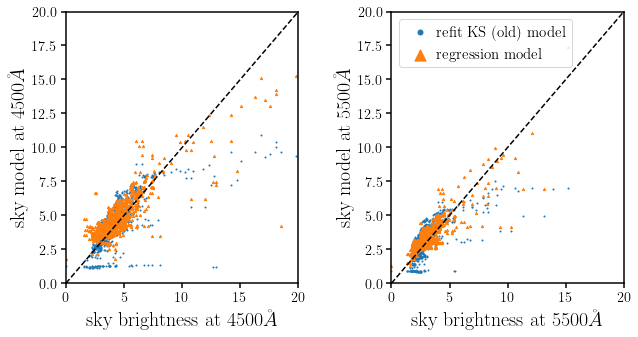

In [31]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(121)
sub.scatter(boss_4500, KSrefit_model_boss_4500, c='C0', s=1)
sub.scatter(desi_4500, KSrefit_model_desi_4500, c='C0', s=1)

sub.scatter(boss_4500, reg_model_boss_4500, c='C1', s=5, marker='^')
sub.scatter(desi_4500, reg_model_desi_4500, c='C1', s=5, marker='^')
sub.plot([0., 20.], [0., 20.], c='k', ls='--')

sub.set_xlabel('sky brightness at $4500 \AA$', fontsize=20)
sub.set_xlim(0., 20.)
sub.set_ylabel('sky model at $4500 \AA$', fontsize=20)
sub.set_ylim(0., 20.)
    
sub = fig.add_subplot(122)
sub.scatter(boss_5500, KSrefit_model_boss_5500, c='C0', s=1)
sub.scatter(desi_5500, KSrefit_model_desi_5500, c='C0', s=1, label='refit KS (old) model')

sub.scatter(boss_5500, reg_model_boss_5500, c='C1', s=5, marker='^')
sub.scatter(desi_5500, reg_model_desi_5500, c='C1', s=5, marker='^', label='regression model')
sub.plot([0., 20.], [0., 20.], c='k', ls='--')

sub.set_xlabel('sky brightness at $5500 \AA$', fontsize=20)
sub.set_xlim(0., 20.)
sub.set_ylabel('sky model at $5500 \AA$', fontsize=20)
sub.set_ylim(0., 20.)
sub.legend(loc='upper left', markerscale=5, handletextpad=0.1, fontsize=15, frameon=True)
fig.subplots_adjust(wspace=0.4)

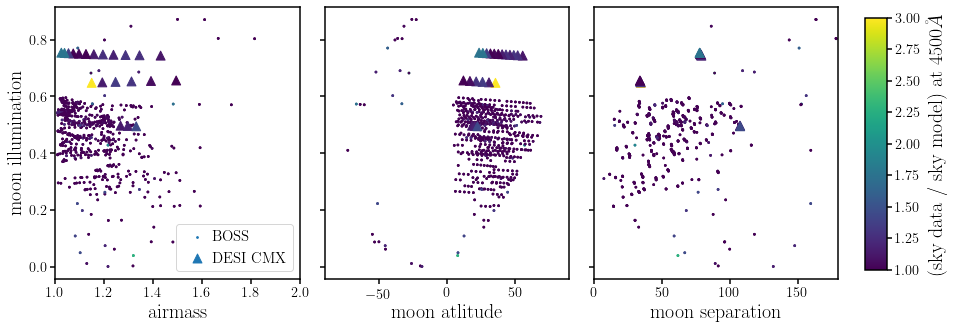

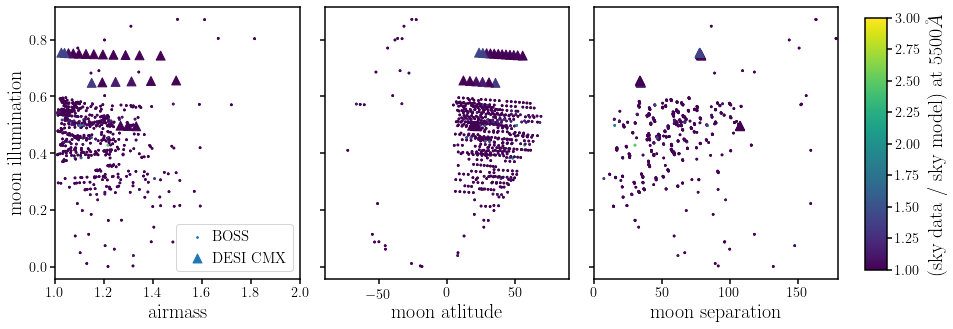

In [32]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c=boss_4500/reg_model_boss_4500, s=3, vmin=1., vmax=3., label='BOSS')
sub.scatter(desi_skies['airmass'], desi_skies['moon_ill'], marker='^', c=desi_4500/reg_model_desi_4500, s=80, vmin=1., vmax=3., label='DESI CMX')
sub.legend(loc='lower right', frameon=True, handletextpad=0, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c=boss_4500/reg_model_boss_4500, s=3, vmin=1., vmax=3.)
sub.scatter(desi_skies['moon_alt'], desi_skies['moon_ill'], marker='^', s=80, c=desi_4500/reg_model_desi_4500, vmin=1., vmax=3.)
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sct = sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c=boss_4500/reg_model_boss_4500, s=3, vmin=1., vmax=3.)
sub.scatter(desi_skies['moon_sep'], desi_skies['moon_ill'], marker='^', c=desi_4500/reg_model_desi_4500, s=80, vmin=1., vmax=3.)
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.875, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sct, cax=cbar_ax)
cbar.set_label(label='(sky data / sky model) at $4500\AA$', fontsize=20)

fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c=boss_5500/reg_model_boss_5500, s=3, vmin=1., vmax=3., label='BOSS')
sub.scatter(desi_skies['airmass'], desi_skies['moon_ill'], marker='^', c=desi_5500/reg_model_desi_5500, s=80, vmin=1., vmax=3., label='DESI CMX')
sub.legend(loc='lower right', frameon=True, handletextpad=0, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c=boss_5500/reg_model_boss_5500, s=3, vmin=1., vmax=3.)
sub.scatter(desi_skies['moon_alt'], desi_skies['moon_ill'], marker='^', s=80, c=desi_5500/reg_model_desi_5500, vmin=1., vmax=3.)
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sct = sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c=boss_5500/reg_model_boss_5500, s=3, vmin=1., vmax=3.)
sub.scatter(desi_skies['moon_sep'], desi_skies['moon_ill'], marker='^', c=desi_5500/reg_model_desi_5500, s=80, vmin=1., vmax=3.)
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.875, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sct, cax=cbar_ax)
cbar.set_label(label='(sky data / sky model) at $5500\AA$', fontsize=20)